# Get the Data

For this section, we will start to get our hands dirty with some real network datasets. Don't be afraid to walk through these examples with your laptop in a jupyter notebook.

## Create the workspace

### Installing the latest version of python

To begin, we will need a suitable instance of python installed. For this book, we used python 3.8, but the most advanced version of python 3 at the time you are reading should do the trick. We will assume that you are using a Linux or UNIX-like operating system, such as OSX. If you have a Windows computer, we would recommend that you use the [Linux subsystem module](#https://www.laptopmag.com/articles/use-bash-shell-windows-10) to interact with the codebase. Once you have this set up and up and running, you can follow the instructions below for a Debian distribution of Linux.

Once you have your computer handy, you can run the following command:

```
$ python3 -V
Python 3.8.0
```

and verify that the python package manager, `pip`, is installed:

```
$ python3 -m pip --version
pip 22.0.3 from /home/<user>/.virtualenvs/graph-book/lib/python3.8/site-packages/pip (python 3.8)
```

This command will print the version of `python3` and `pip` that your computer currently has installed. If it returns any version below `3.8.x` or says "command not found", you will need to obtain and install python 3 (along with the developer libraries and the package manager, `pip`) before continuing. The developer libraries are critical to ensuring that code upon which packages in python are based (such as the popular `numpy` numerical package) have the appropriate libraries needed to execute code written in *other* programming languages, which might be faster (for instance, `C`). 

If you have an apple computer using the OSX operating system, you can download and install an appropriate version of python using [The python 3 guide for OSX](#https://docs.python-guide.org/starting/install3/osx/) by first configuring `homebrew` and then installing python. This will also include `pip`. 

If you are using a Debian-based Linux distribution (such as Ubuntu), you can install python 3 along with the developer libraries and `pip` by typing:

```
$ sudo apt-get update
$ sudo apt-get install -y python3-dev python3-pip
```

If you have a CentOS distribution (such as CentOS or Red Hat), you can install python3 along with the developer libraries and `pip` by typing:

```
$ sudo yum update
$ sudo yum install -y python3-devel python3-pip
```

You should make sure that you have the most recent version of `pip` installed. To upgrade the current `pip` package, type:

```
$ python3 -m pip install --user -U pip
Collecting pip
[...]
Successfully installed pip-22.0.3
```

You now have `python3`, the python package manager `pip`, and the `python3` developer libraries installed on your computer. 

### Installing fortran

Some of the packages that we will use in the book require the system to have an appropriate version of a programming language called FORTRAN installed. FORTRAN is a numerical programming language which is very fast for mathematical computations. Fortran is included in the package `gcc`, which is a collection of compilers for many programming languages.

If you have a MAC system, you can install `gfortran` with the following command:

```
$ sudo brew install gcc
```

If you have a Debian system, you can install `gfortran` with the following command:

```
$ sudo apt-get update
$ sudo apt-get install gcc
```

If you have a CentOS system, you can install `gfortran` with the following command:

```
$ sudo yum update
$ sudo yum install gcc
```

### Establishing a virtual environment

It is often good practice in python to avoid installing many packages directly to `python3` itself. This is because packages in python do not necessarily have the same dependencies, and particular projects might require package versions that conflict with other projects you are working on. For instance, I might have a homework assignment that works only with numpy version 1.18.1, but meanwhile, a work project needs numpy version 1.22.0. For this reason, we strongly encourage you to use virtual environments.

To begin working with virtual environments in python, we will need to first obtain the `virtualenv` python package:

```
$ pip3 install virtualenv
Collecting package virtualenv
[...]
Successfully installed virtualenv-20.13.1
```

Once we have `virtualenv` installed, we can create our first virtual environment in python. We will first make a directory in our home directory which will allow us to keep track of our virtual environments, and then we will make a new virtual environment for the book which uses `python3`:

```
$ # create a new directory for virtual environments
$ mkdir ~/.virtualenvs
$ # make a new virtual environment using python3
$ virtualenv -p python3 ~/.virtualenvs/graph-book
```

Every time you want to use run code for the book, you should first use the following command to activate the virtual environment:

```
$ # activate the virtual env
$ source ~/.virtualenv/bin/activate
(graph-book) $ 
```

You should run this command before continuing to the next section.

### Installing the dependencies for the book

Next, we need to install the python package dependencies for the book. Once you have your virtual environment activated, you will next want to grab the requirements file for the graph book, which can be obtained by typing:


```
(graph-book) $ wget https://raw.githubusercontent.com/neurodata/graph-stats-book/master/requirements.txt
```

Next, you will want to install the appropriate python packages specified in the `requirements.txt` file, by typing:

```
(graph-book) $ pip install -r requirements.txt
```

Since you are in a virtual environment, you no longer have to worry about making sure you are installing these to `python3` or `pip3`, since the virtual environment streamlines all of these function calls for us directly. Finally, we will need to install `jupyter-lab` and the ipython kernel, using the following commands:


```
(graph-book) $ pip install jupyterlab ipykernel
```

We need to add our virtual environment to the ipython kernel so that jupyter lab can find it, which we can do by typing:


```
(graph-book) $ python -m ipykernel install --user --name=graph-book
Installed kernelspec myenv in /home/<user>/.local/share/jupyter/kernels/graph-book
```

This will ensure that packages you install to the `graph-book` virtual environment will be findable from within jupyter.

### Setting up jupyter notebook

Now that we have all our packages installed, we can finally move to starting up a notebook. Let's begin by first launching jupyter lab:

```
(graph-book) $ jupyter-lab

```

Next, we want to create a new notebook using the `graph-book` module, as shown in Figure {numref}`graphbook-mod`:

```{figure} ../../Images/jupyter.png
---
scale: 80%
align: center
name: graphbook-mod
---
Select the graph-book kernel, indicated by the red box.
```

To verify that your notebook has the proper software installed, we will make a code cell which simply imports the `graspologic` package, by typing the following command in the top cell:

```
import graspologic
graspologic.__version__
```

and then pressing the `Shift + Enter` keys simultaneously. Note that this cell will take a few seconds to execute successfully. In your notebook, this will look like {numref}`graphbook-grasp`:


```{figure} ../../Images/jupyter_grasp.png
---
scale: 80%
align: center
name: graphbook-grasp
---
Make sure that graspologic package imports, by verifying that it can print its version successfully.
```

From this point forward, for each section of the book, you should be able to copy and paste code snippets section by section, and successfully reproduce the executable code contained within the book. You should take care to make sure that if you take this approach that you make sure to copy and paste all code that appears in the section, since there may be modules which are imported in above cells that are assumed to have been imported in later cells. 

## Downloading the data

When you work with network data, it is rarely the case that the *raw data* that you will use is already a network. The **raw data** is the least processed version of the data for your project, and is the information upon which the rest of your data is *derived*. A **derivative** is a piece of data or information that is *derived* from the raw data. Consider, for instance, that you are investigating emailing trends for a company, and trying to see whether employees tend to email their team members more or less frequently than people outside of their team. In this case, your raw data might be a list of emails, coupled with the sender, and the recipient, of each email. You might be responsible for *preprocessing* this data to acquire a network derivative for your later analyses.

In this section, we won't worry just yet about preprocessing a raw dataset, and will instead start with some pre-prepared data. We will be working with the left and right mushroom bodies of the *drosophila* (fruit fly). We could navigate over to the github repository for the `graspologic` package and download the file directly, but it tends to be useful to do this programmatically. This is because if the data changes, you might want your analysis to automatically update and pertain to the latest and best version of the data at the time you execute your function. Further, if you intend your code to be reproducible, having a function which downloads and prepares the data in a way in which the computer can use greatly will simplify the process of disseminating your work. 

First, we fetch the desired data. The `DROS_NAMES` variable just stores the adjacency matrix `"A"` and the corresponding labels for each node `"labels"`, which we will use later on:

In [16]:
import os
import urllib


MSR_ROOT = "https://raw.githubusercontent.com/microsoft/graspologic/dev/"
DROS_PATH = os.path.join("datasets", "drosophila")
DROS_URL = MSR_ROOT + "graspologic/datasets/drosophila"

DROS_NAMES = {"Left": {"A": "left_adjacency.csv", "labels": "left_cell_labels.csv"},
              "Right": {"A": "right_adjacency.csv", "labels": "right_cell_labels.csv"}}

def fetch_drosophila_data(dros_url=DROS_URL, dros_path=DROS_PATH,
                         dros_names=DROS_NAMES):
    if not os.path.isdir(dros_path):
        os.makedirs(dros_path)
    for (name, dictobj) in dros_names.items():
        for (objtype, fname) in dros_names[name].items():
            csv_path = os.path.join(dros_path, fname)
            csv_url = os.path.join(dros_url, fname)
            urllib.request.urlretrieve(csv_url, csv_path)

Now when we call `fetch_drosophila_data()`, it creates a new directory called `datasets/drosophila` in your workspace, and downloads the left and right adjacency matrices as csvs to this directory.

Next, we'll try to load the dataset using the standard `loadtxt()` from `numpy`. We should build a small function to do this for us:

In [17]:
import numpy as np


def load_drosophila_data(dros_path=DROS_PATH, dros_names=DROS_NAMES,
                        return_labels=True):
    adj_dict = {}  # make the return object
    for (name, dictobj) in dros_names.items():
        adj_dict[name] = {}  # dictionary for each adjacency matrix with labels
        
        adj_path = os.path.join(dros_path, dictobj["A"])
        with open(adj_path) as adjfile:
            adj_dict[name]["A"] = np.loadtxt(adjfile)
        
        labels_path = os.path.join(dros_path, dictobj["labels"])
        with open(labels_path) as labelfile:
            adj_dict[name]["labels"] = np.loadtxt(labelfile, dtype=str)
    return adj_dict

Next, let's fetch the data and load it into our environment:

In [20]:
fetch_drosophila_data()
dataset = load_drosophila_data()

Let's take a look at the data we've loaded:

In [57]:
print(dataset.keys())

dict_keys(['Left', 'Right'])


There are separate keys for the left and the right of the drosophila. Let's see what the left contains:

In [58]:
print(dataset["Left"].keys())

dict_keys(['A', 'labels'])


We have two keys here, one for the adjacency matrix of the network (often abbreviated with `"A"`, as we have here), and another called `"labels"`, which are attributes for each of the nodes of the adjacency matrix.

Let's take a look at the size of each of these objects:

In [59]:
print(dataset["Left"]["A"].shape)
print(dataset["Left"]["labels"].shape)

(209, 209)
(209,)


As we can see, `"A"` is a square matrix with 209 rows and columns (one for each node of the network), and `"labels"` is a vector with 209 elements (one for each node of the network). Let's look at the types of the entries of each element. First, we'll look at the adjacency matrix:

In [60]:
print(dataset["Left"]["A"].dtype)

float64


So the adjacency matrix is a square matrix of floating-precision numerical values, and the labels:

In [61]:
print(dataset["Left"]["labels"].dtype)

<U1


Is a vector of unicode characters. Next, let's learn some things about this adjacency matrix. We start by first breaking the dictionary into individual data objects so our code is a little more readable. In network machine learning, when dealing with a new dataset, our recommendation is to *always*, *always*, start with visualization. We typically visualize network data using a heatmap:

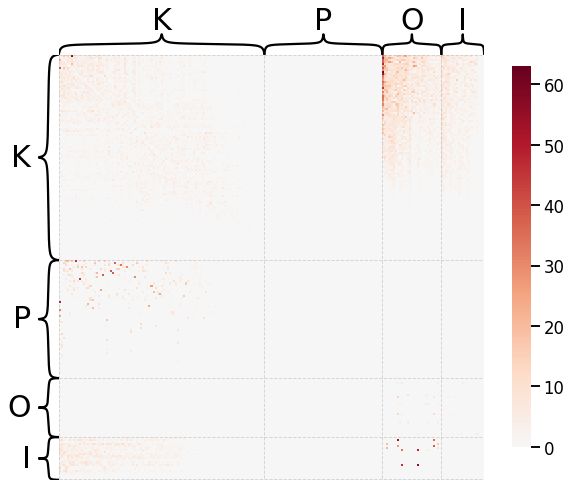

In [62]:
import graspologic as gp

Aleft=dataset["Left"]["A"]
labelsleft=dataset["Left"]["labels"]
Aright=dataset["Right"]["A"]
labelsright=dataset["Right"]["labels"]

ax = gp.plot.heatmap(Aleft, inner_hier_labels=labelsleft)

What this has done is it has plotted the adjacency matrix for the left mushroom body of the drosophila as a heatmap. A heatmap is a network visualization in which the $x$ and $y$ coordinates of a given entry in the matrix indicate the pair of nodes an edge is connected to, and the color for the $(x,y)$ point in the figure indicates the weight of the edge between nodes $x$ and $y$. The nodes are also organized by their label. For instance, in this case, all of the nodes with the label `K` are in the top rows and the left columns, all the nodes with the label `P` are in the second set of rows and the second set of columns, so on and so forth.

One thing we might be able to notice from the above plot is that a lot of these edge-weights are just $0$. We can compute the fraction of non-zero edges using the below code snippet:

In [66]:
print("fraction of non-zero edge-weights: {:.3f}".format((Aleft > 0).mean()))

fraction of non-zero edge-weights: 0.170


A useful summary of the network is to look at a histogram for the non-zero edgeweights. A histogram shows the number of edges (on the vertical axis) which have a given edge weight range (on the horizontal axis). You can call this directly on the non-zero-edges, and it will plot a histogram of the edge weights. We will do this using seaborn's `distplot()`:

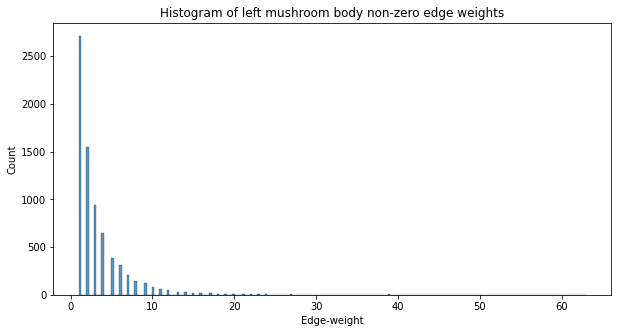

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(10, 5))
sns.histplot(Aleft[Aleft > 0], ax=ax);
ax.set_xlabel("Edge-weight")
ax.set_title("Histogram of left mushroom body non-zero edge weights");

So as we can see, most of the edge-weights are very small, and as the edge weight increases, fewer and fewer edges have the indicated edge weight. This is called a positive-skewed tail, which there is a long "tail" (the very small histograms indicated above) that goes in the positive direction on the horizontal edge-weight axis.